In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from IPython.display import display, HTML
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score

plt.rcParams["figure.figsize"] = (20,8)

In [4]:
tmax = pd.read_csv("new_england_tmax.csv", index_col = "date", parse_dates=True)
tavg = pd.read_csv("new_england_tavg.csv", index_col = "date", parse_dates=True)
tmin = pd.read_csv("new_england_tmin.csv", index_col = "date", parse_dates=True)
prcp = pd.read_csv("new_england_prcp.csv", index_col = "date", parse_dates=True)

In [5]:
tavg

,measurement
date,
1951-01-01,-7.01
1951-01-02,-6.75
1951-01-03,-1.29
1951-01-04,4.18
1951-01-05,-0.57
...,...
2021-12-27,-2.83
2021-12-28,-3.98
2021-12-29,-1.90


explain rolling mean
#TODO make window backward looking

<AxesSubplot:xlabel='date'>

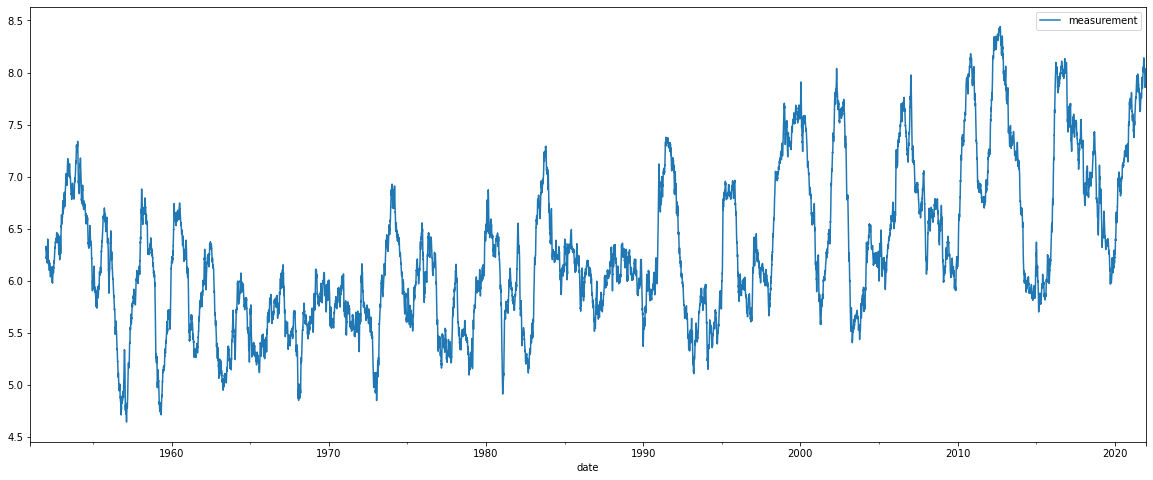

In [6]:
rolling_mean =tavg.rolling(366).mean()
rolling_mean.plot()

In [7]:
rolling_mean.loc["1951-12-25":"1952-01-05"]
# notice exactly one year Nan

,measurement
date,
1951-12-25,NaN
1951-12-26,NaN
1951-12-27,NaN
1951-12-28,NaN
1951-12-29,NaN
1951-12-30,NaN
1951-12-31,NaN
1952-01-01,6.300437
1952-01-02,6.323169


#TODO explain differencing

<AxesSubplot:xlabel='date'>

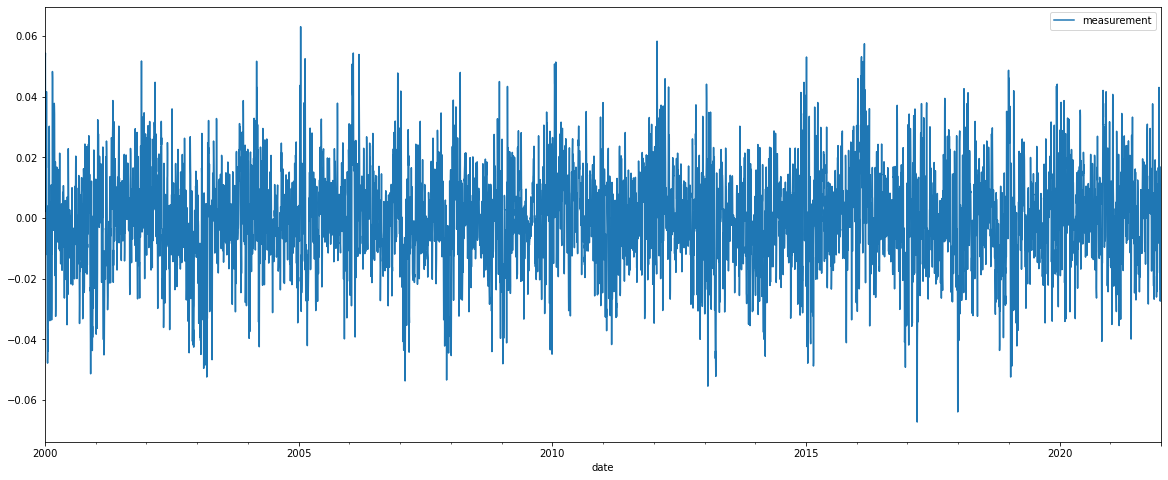

In [8]:
rolling_mean_diff = rolling_mean.diff()

rolling_mean_diff["2000-01-01":].plot()


In [9]:
dftest = adfuller(rolling_mean_diff.dropna(), autolag = 'AIC')
p_value = dftest[1]


print("p value:",p_value, "statistic",dftest[0]) # low p value indicates stationary

p value: 0.0 statistic -43.498981966900836


<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

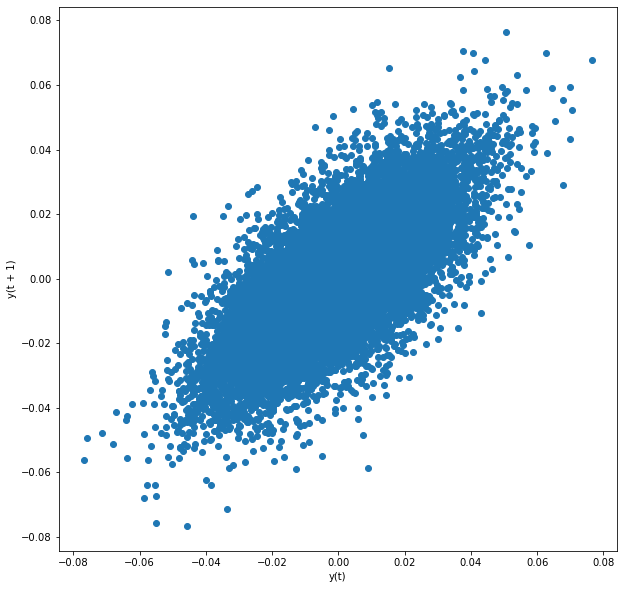

In [10]:
plt.figure(figsize=(10,10))
pd.plotting.lag_plot(rolling_mean_diff, lag=(1))

<AxesSubplot:xlabel='date'>

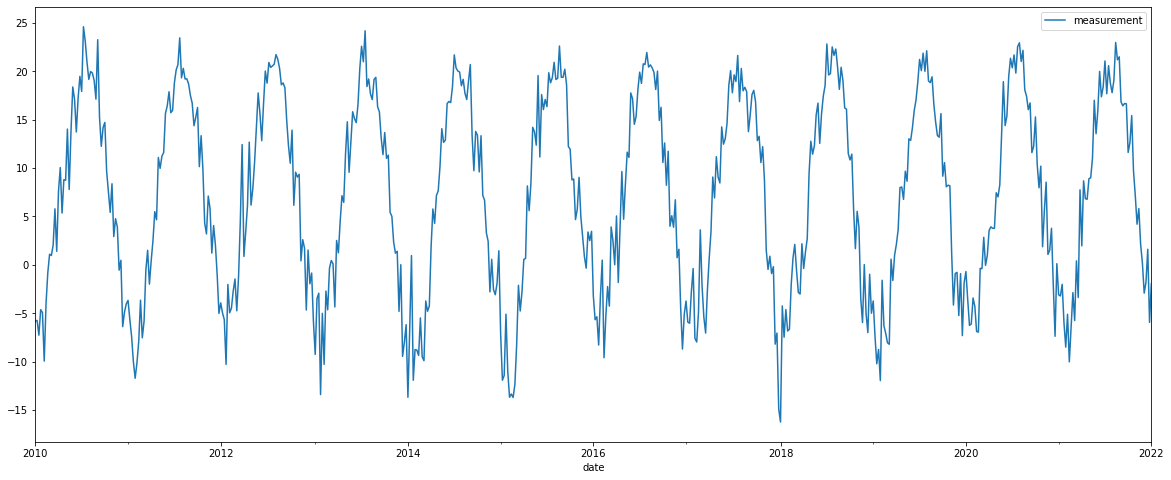

In [11]:
weekly = tavg.resample("W").mean()
weekly["2010-01-01":].plot()

In [12]:
x = ExponentialSmoothing(tavg,trend='add',seasonal='add',seasonal_periods=52, freq="D")


In [13]:
x.fit()

AttributeError: 'ExponentialSmoothing' object has no attribute 'fittedvalues'

In [54]:
model=sm.tsa.statespace.SARIMAX(weekly["1980-01-01":"2018-01-01"],order=(1, 1, 1),seasonal_order=(1,1,1,52))
        

In [55]:
results=model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.59456D+00    |proj g|=  8.76516D-02

At iterate    5    f=  2.46345D+00    |proj g|=  1.50139D-02

At iterate   10    f=  2.46218D+00    |proj g|=  5.26148D-03

At iterate   15    f=  2.45956D+00    |proj g|=  5.55408D-03

At iterate   20    f=  2.45806D+00    |proj g|=  1.88305D-02

At iterate   25    f=  2.45718D+00    |proj g|=  4.70411D-04

At iterate   30    f=  2.45714D+00    |proj g|=  1.07299D-04

At iterate   35    f=  2.45714D+00    |proj g|=  1.50315D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected 

<AxesSubplot:xlabel='date'>

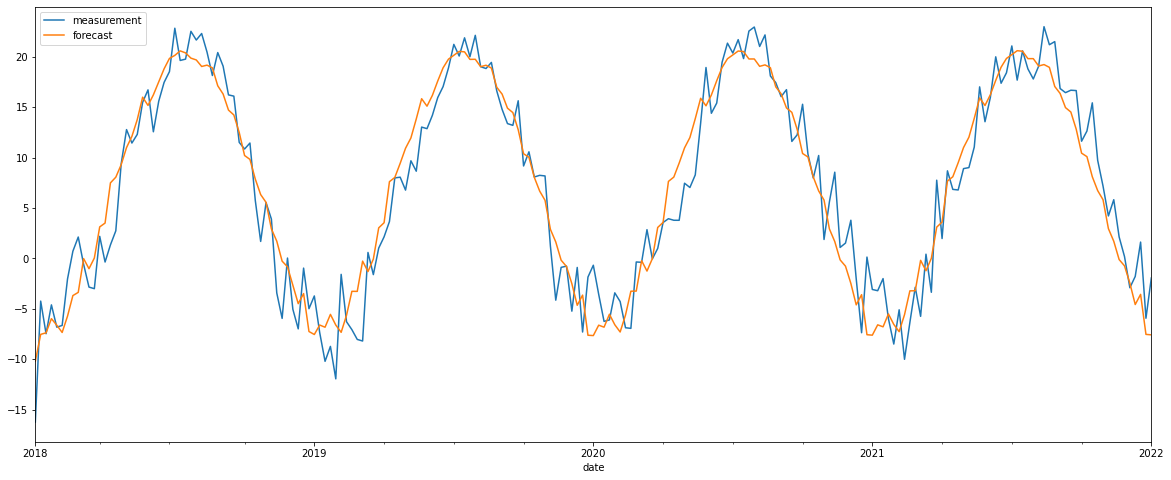

In [88]:
weekly['forecast']= results.predict(start="2018-01-01", end="2022-12-31")
weekly["2018-01-01":].plot()

In [105]:
x = weekly["measurement"].loc["2018-01-01":]
y = weekly["forecast"].loc["2018-01-01":]
mae(x,y)

2.398826696585481

In [103]:
r2 = r2_score(y, x)
r2

0.9050987534865166

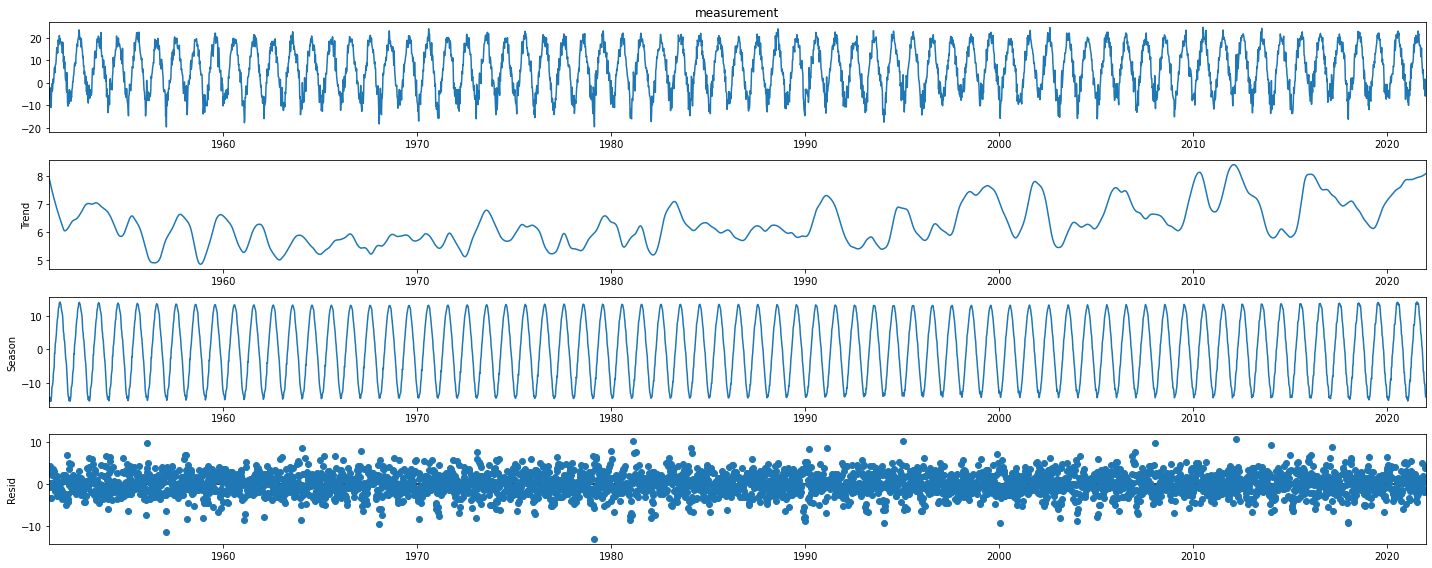

In [118]:
stl = STL(weekly["measurement"], seasonal=53)
res = stl.fit()
fig = res.plot()

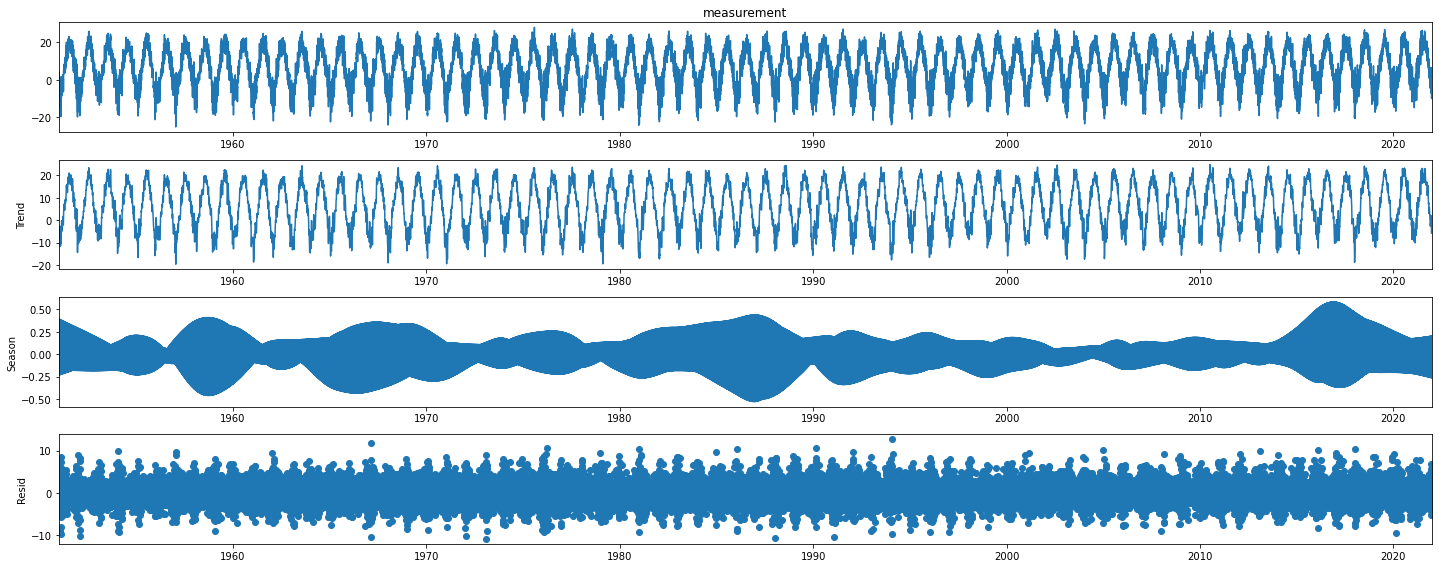

In [119]:
stl = STL(tavg["measurement"], seasonal=365)
res = stl.fit()
fig = res.plot()

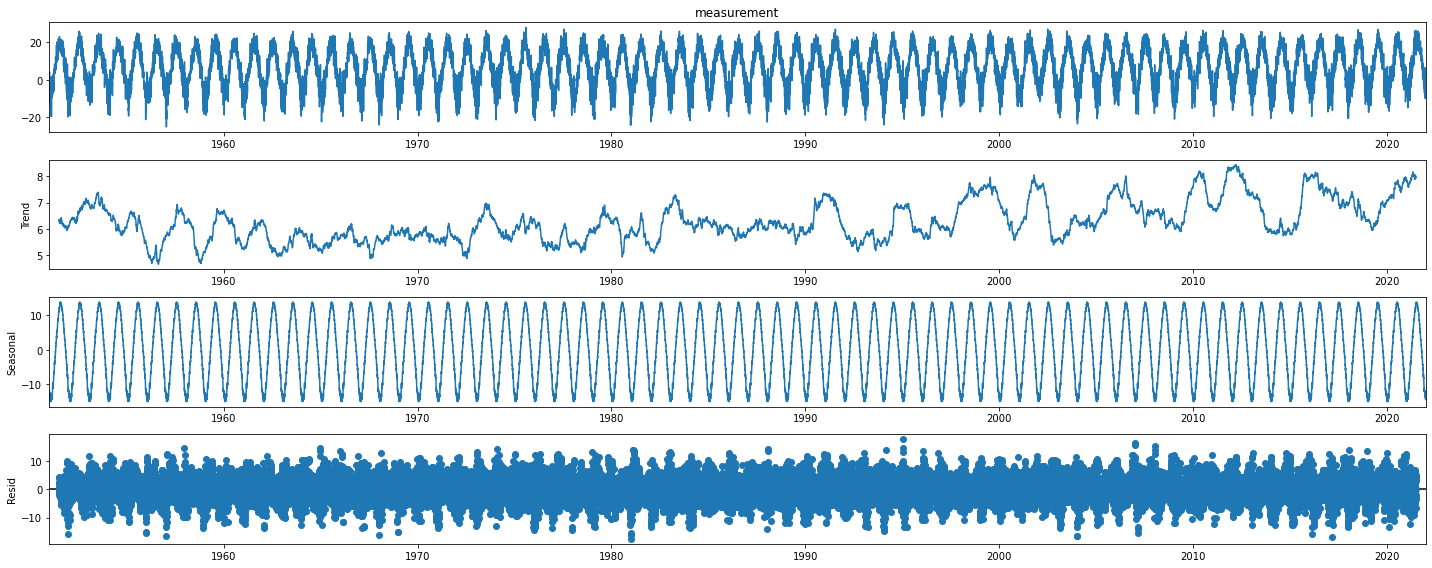

In [79]:
decomposition = sm.tsa.seasonal_decompose(tavg["measurement"], period = 365, model='additive')
fig = decomposition.plot()


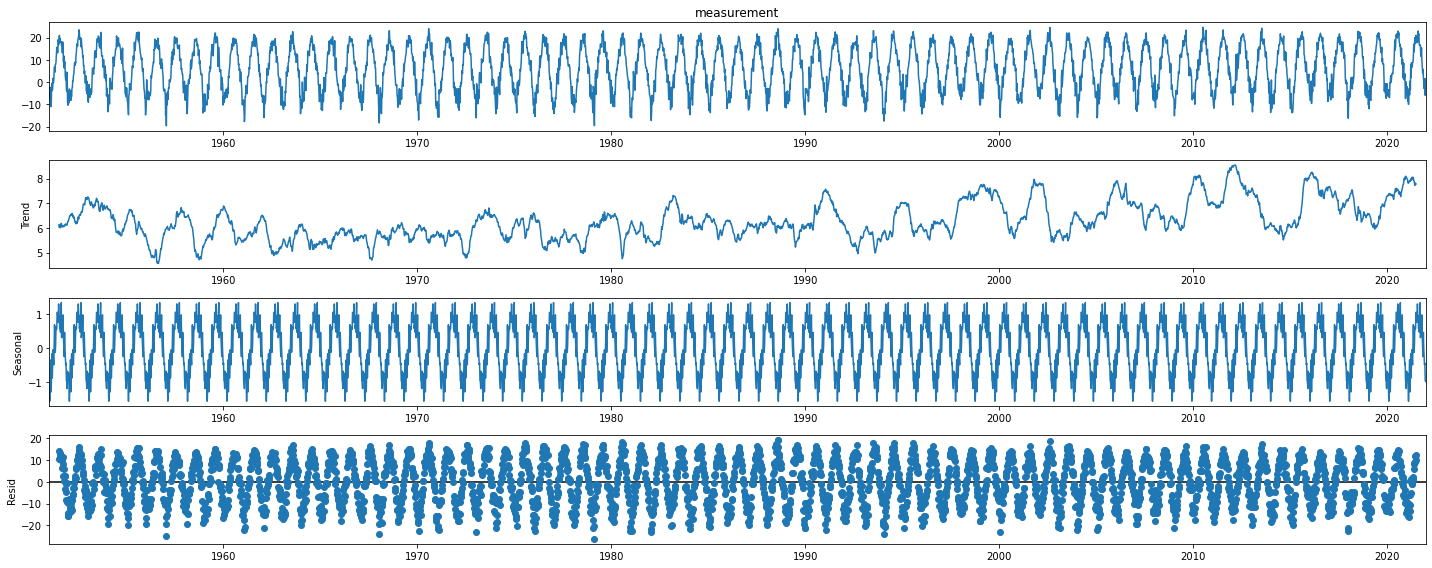

In [123]:

decomposition = sm.tsa.seasonal_decompose(weekly["measurement"], period = 53, model='additive')
fig = decomposition.plot()
